In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import joblib

In [33]:
meps = pd.read_stata("h243.dta")
meps

,DUID,PID,DUPERSID,PANEL,DATAYEAR,FAMID31,FAMID42,FAMID53,FAMID22,FAMIDYR,...,RXOSR22,RXPTR22,RXOTH22,PERWT22F,FAMWT22F,FAMWT22C,SAQWT22F,DIABW22F,VARSTR,VARPSU
0,2460002,101,2460002101,24 PANEL 24,2022 YEAR,A,A,A,A,A,...,0,0,0,5728.309495,5232.211986,5232.211986,3994.687140,6034.636755,2082,1
1,2460006,101,2460006101,24 PANEL 24,2022 YEAR,A,A,A,A,A,...,0,0,0,15648.881461,16017.881691,16017.881691,0.000000,0.000000,2001,4
2,2460006,102,2460006102,24 PANEL 24,2022 YEAR,A,A,A,A,A,...,0,0,0,14123.720178,16017.881691,12580.731740,0.000000,0.000000,2001,4
3,2460010,101,2460010101,24 PANEL 24,2022 YEAR,A,A,A,A,A,...,0,5288,299,16982.054917,21905.758877,21905.758877,0.000000,0.000000,2038,3
4,2460018,101,2460018101,24 PANEL 24,2022 YEAR,A,A,A,A,A,...,0,10,0,10682.619947,11344.291012,11344.291012,17152.439412,0.000000,2041,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22426,2799694,101,2799694101,27 PANEL 27,2022 YEAR,A,A,A,A,A,...,0,231,0,21490.058502,24757.243908,24757.243908,30689.883735,0.000000,2015,2
22427,2799694,102,2799694102,27 PANEL 27,2022 YEAR,A,A,A,A,A,...,0,79,0,18828.710297,24757.243908,24757.243908,22648.236877,0.000000,2015,2
22428,2799695,101,2799695101,27 PANEL 27,2022 YEAR,A,A,A,A,A,...,0,0,0,15992.756873,18382.130170,18382.130170,20512.235130,0.000000,2045,1
22429,2799698,101,2799698101,27 PANEL 27,2022 YEAR,A,A,A,A,A,...,0,578,0,15771.415106,15430.797933,15430.797933,0.000000,0.000000,2103,3


In [34]:
df = meps  

wanted_cols = [
    # ID (keep DUPERSID)
    "DUPERSID",

    # Demographics
    "AGE22X", "SEX", "RACEV2X", "HISPANX", "MARRY22X",
    "EDUCYR", "FTSTU22X", "REGION22", 

    # Socioeconomic / Income
    "POVCAT22", "FAMINC22", "TTLP22X", "WAGEP22X", "BUSNP22X", "EMPST53",

    # Self-reported health & mental health
    "RTHLTH53", "MNHLTH53", "IADLHP31", "ADLHLP31",
    "ANYLMI22", "K6SUM42", "PHQ242",

    # Chronic conditions
    "HIBPDX", "CHDDX", "ANGIDX", "MIDX", "STRKDX", "EMPHDX",
    "CHOLDX", "CANCERDX", "ARTHDX", "ARTHTYPE", "ASTHDX",
    "ADHDADDX", "DIABDX_M18",

    # Insurance coverage
    "INSCOV22", "INSURC22", "PRVEV22", "TRIEV22",
    "MCREV22", "MCDEV22", "VAEV22", "UNINS22",

    # Utilization / Other
    "ERTOT22", "IPDIS22", "RXTOT22", "PERWT22F",

    # Target
    "TOTEXP22",
]

model_cols = [c for c in wanted_cols if c in df.columns]

meps = df[model_cols].copy()

In [35]:
# Demographics
meps.head().iloc[:, 0:9]

# Age top coded at 85 (85 indicates >= 85)

,DUPERSID,AGE22X,SEX,RACEV2X,HISPANX,MARRY22X,EDUCYR,FTSTU22X,REGION22
0,2460002101,77,2 FEMALE,2 BLACK - NO OTHER RACE REPORTED,2 NOT HISPANIC,2 WIDOWED,6,-1 INAPPLICABLE,2 MIDWEST
1,2460006101,64,2 FEMALE,1 WHITE - NO OTHER RACE REPORTED,2 NOT HISPANIC,3 DIVORCED,14 2 YEARS COLLEGE,-1 INAPPLICABLE,2 MIDWEST
2,2460006102,67,1 MALE,1 WHITE - NO OTHER RACE REPORTED,2 NOT HISPANIC,3 DIVORCED,17 5+ YEARS COLLEGE,-1 INAPPLICABLE,2 MIDWEST
3,2460010101,29,1 MALE,12 MULTIPLE RACES REPORTED,2 NOT HISPANIC,5 NEVER MARRIED,16 4 YEARS COLLEGE,-1 INAPPLICABLE,4 WEST
4,2460018101,51,2 FEMALE,1 WHITE - NO OTHER RACE REPORTED,2 NOT HISPANIC,3 DIVORCED,16 4 YEARS COLLEGE,-1 INAPPLICABLE,1 NORTHEAST


In [36]:
# Socioeconomic / Income
meps.head().iloc[:, 9:15]

,POVCAT22,FAMINC22,TTLP22X,WAGEP22X,BUSNP22X,EMPST53
0,3 LOW INCOME,22000,22000,0,0,4 NOT EMPLOYED DURING RD 5/3
1,1 POOR/NEGATIVE,5000,5000,0,-4000,4 NOT EMPLOYED DURING RD 5/3
2,4 MIDDLE INCOME,30740,30740,20240,0,3 JOB DURING RD 5/3 REF PERIOD
3,5 HIGH INCOME,106483,106483,106483,0,1 EMPLOYED AT RD 5/3 INT DATE
4,4 MIDDLE INCOME,45000,45000,45000,0,1 EMPLOYED AT RD 5/3 INT DATE


In [37]:
# health & mental health
meps.head().iloc[:, 15:22]

,RTHLTH53,MNHLTH53,IADLHP31,ADLHLP31,ANYLMI22,K6SUM42,PHQ242
0,3 GOOD,3 GOOD,1 YES,2 NO,1 YES,12,2
1,5 POOR,1 EXCELLENT,2 NO,2 NO,1 YES,-1 INAPPLICABLE,-1 INAPPLICABLE
2,1 EXCELLENT,1 EXCELLENT,2 NO,2 NO,2 NO,-1 INAPPLICABLE,-1 INAPPLICABLE
3,4 FAIR,3 GOOD,2 NO,2 NO,2 NO,-1 INAPPLICABLE,-1 INAPPLICABLE
4,2 VERY GOOD,4 FAIR,2 NO,2 NO,2 NO,5,1


In [38]:
# Chronic conditions
meps.head().iloc[:, 22:35]

,HIBPDX,CHDDX,ANGIDX,MIDX,STRKDX,EMPHDX,CHOLDX,CANCERDX,ARTHDX,ARTHTYPE,ASTHDX,ADHDADDX,DIABDX_M18
0,1 YES,2 NO,2 NO,2 NO,1 YES,2 NO,1 YES,1 YES,1 YES,3 NOT SPECIFIED,2 NO,-1 INAPPLICABLE,1 YES
1,1 YES,2 NO,2 NO,1 YES,2 NO,2 NO,2 NO,1 YES,1 YES,2 OSTEOARTHRITIS,2 NO,-1 INAPPLICABLE,2 NO
2,2 NO,2 NO,2 NO,2 NO,2 NO,2 NO,2 NO,2 NO,2 NO,-1 INAPPLICABLE,2 NO,-1 INAPPLICABLE,2 NO
3,2 NO,2 NO,2 NO,2 NO,2 NO,2 NO,2 NO,2 NO,2 NO,-1 INAPPLICABLE,2 NO,-1 INAPPLICABLE,2 NO
4,2 NO,2 NO,2 NO,2 NO,2 NO,2 NO,1 YES,2 NO,1 YES,2 OSTEOARTHRITIS,1 YES,-1 INAPPLICABLE,2 NO


In [39]:
# Insurance
meps.head().iloc[:, 35:43]

,INSCOV22,INSURC22,PRVEV22,TRIEV22,MCREV22,MCDEV22,VAEV22,UNINS22
0,2 PUBLIC ONLY,6 65+ EDITED MEDICARE AND OTH PUB ONLY,2 NO,2 NO,1 YES,1 YES,2 NO,2 NO
1,2 PUBLIC ONLY,2 <65 PUBLIC ONLY,2 NO,2 NO,1 YES,1 YES,2 NO,2 NO
2,2 PUBLIC ONLY,6 65+ EDITED MEDICARE AND OTH PUB ONLY,2 NO,2 NO,1 YES,1 YES,2 NO,2 NO
3,1 ANY PRIVATE,1 <65 ANY PRIVATE,1 YES,2 NO,2 NO,2 NO,2 NO,2 NO
4,1 ANY PRIVATE,1 <65 ANY PRIVATE,1 YES,2 NO,2 NO,2 NO,2 NO,2 NO


In [40]:
# Utilization / Weight
meps.head().iloc[:, 43:47]

,ERTOT22,IPDIS22,RXTOT22,PERWT22F
0,0,0,40,5728.309495
1,2,0,43,15648.881461
2,0,0,1,14123.720178
3,0,0,36,16982.054917
4,0,0,23,10682.619947


In [41]:
# Target (total annual health care expenditures for an individual in calendar year 2022)
meps[["TOTEXP22"]].head()

,TOTEXP22
0,15766
1,12697
2,3405
3,9265
4,3362


In [42]:
rename_map = {
    # IDs
    "DUPERSID": "person_id",

    # Demographics
    "AGE22X": "age",
    "SEX": "sex",
    "RACEV2X": "race",
    "HISPANX": "hispanic",
    "MARRY22X": "marital_status",
    "EDUCYR": "education_years",
    "FTSTU22X": "is_student",
    "REGION22": "region_2022",

    # SES / income / employment
    "POVCAT22": "poverty_category",
    "FAMINC22": "family_income",          # (often categorical or edited; keep name explicit)
    "TTLP22X": "total_family_income",
    "WAGEP22X": "wage_income",
    "BUSNP22X": "business_income",
    "EMPST53": "employment_status",   # “53” ≈ end-of-year / late-round status (end of the year)

    # Self-reported health (end-of-year style)
    "RTHLTH53": "self_rated_health",                # (end of the year)
    "MNHLTH53": "self_rated_mental_health",

    # Functioning / disability help (round-based)
    "IADLHP31": "needs_help_iadl",       # IADL = instrumental activities of daily living
    "ADLHLP31": "needs_help_adl",        # ADl = acitivities of daily living

    # Mental health / distress scales
    "ANYLMI22": "any_mental_illness",
    "K6SUM42": "k6_distress_score",  # (round 4)
    "PHQ242": "phq2_depression_score",

    # Diagnoses (ever told by a doctor, typically)
    "HIBPDX": "dx_hypertension",
    "CHDDX": "dx_coronary_heart_disease",
    "ANGIDX": "dx_angina",
    "MIDX": "dx_myocardial_infarction",
    "STRKDX": "dx_stroke",
    "EMPHDX": "dx_emphysema",
    "CHOLDX": "dx_high_cholesterol",
    "CANCERDX": "dx_cancer",
    "ARTHDX": "dx_arthritis",
    "ARTHTYPE": "arthritis_type",
    "ASTHDX": "dx_asthma",
    "ADHDADDX": "dx_adhd_add",
    "DIABDX_M18": "dx_diabetes",

    # Insurance coverage
    "INSCOV22": "insured_full_year",       # coverage continuity style variable
    "INSURC22": "insurance_type",          # private/public/uninsured style category
    "PRVEV22": "has_private_insurance",
    "TRIEV22": "has_tricare",
    "MCREV22": "has_medicare",
    "MCDEV22": "has_medicaid",
    "VAEV22": "has_va_coverage",
    "UNINS22": "uninsured_status",

    # Spending components / utilization totals
    "ERTOT22": "er_expenditure",
    "IPDIS22": "inpatient_expenditure",
    "RXTOT22": "prescription_expenditure",

    # Weights
    "PERWT22F": "person_weight",

    # Target
    "TOTEXP22": "total_healthcare_expenditure",
}

meps = meps.rename(columns=rename_map)


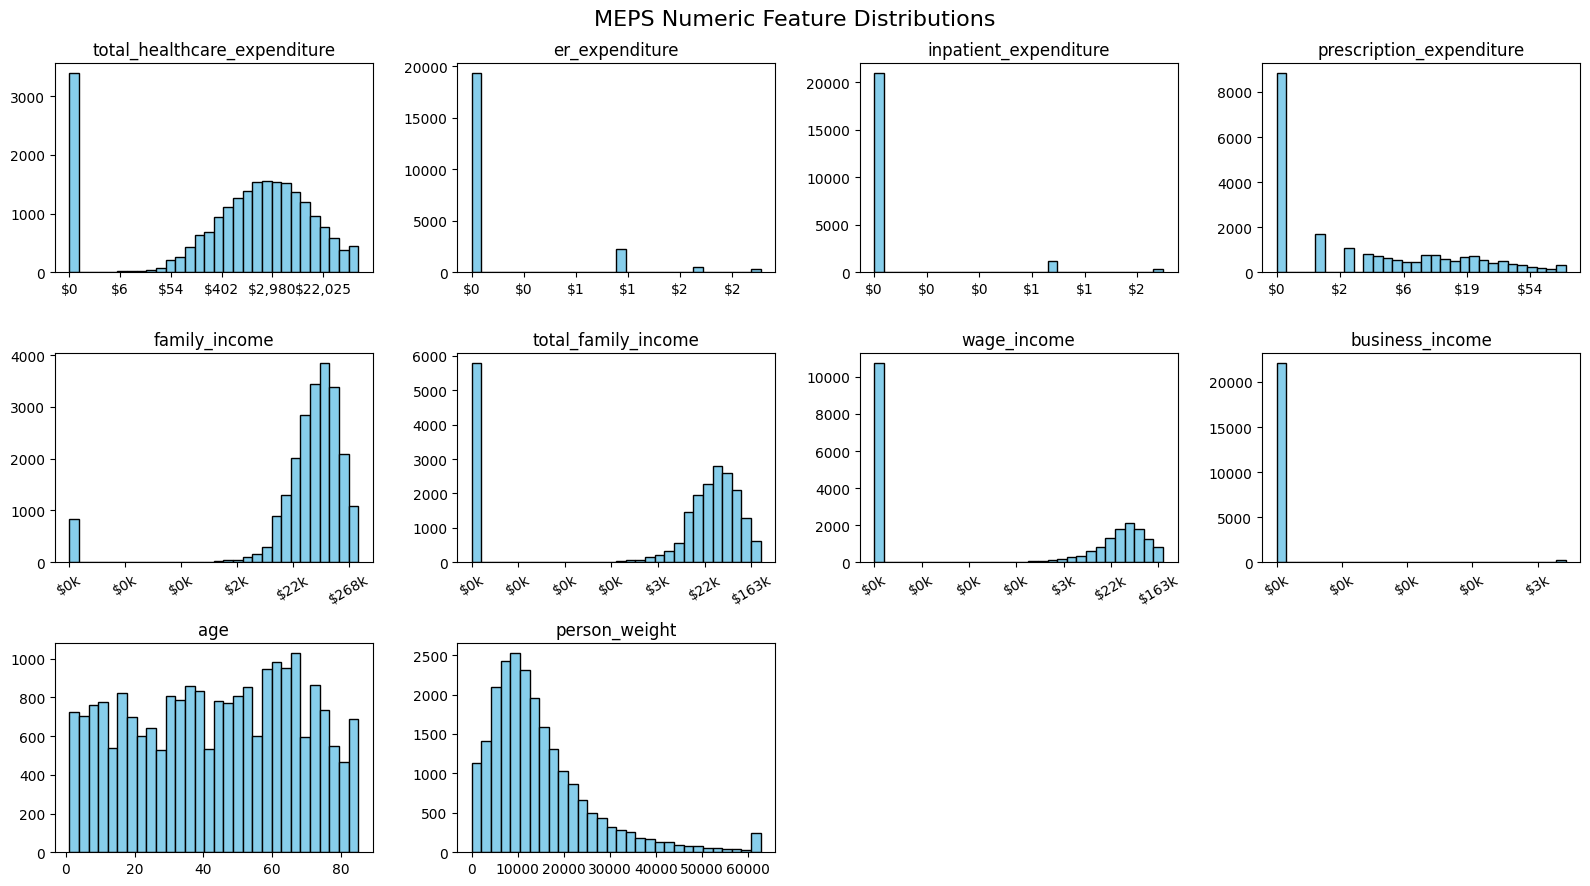

In [43]:
# Hardcoded histogram visualization for truly numeric MEPS features

# Helper functions to reduce repetition
def clean_meps_missing(series):
    """Replace MEPS reserved codes with NaN."""
    return series.replace({-1: np.nan, -2: np.nan, -7: np.nan, -8: np.nan, -9: np.nan, -10: np.nan, -13: np.nan, -15: np.nan})

def log1p_transform(series):
    """Apply log1p transformation to a series."""
    return np.log1p(series.astype(float))

def signed_log1p_transform(series):
    """Apply signed log1p transformation (handles negative values)."""
    return np.sign(series.astype(float)) * np.log1p(np.abs(series.astype(float)))

def clip_outliers(series):
    """Clip series to 1st and 99th percentiles."""
    return series.clip(series.quantile(0.01), series.quantile(0.99))

def dollar_formatter(x, pos):
    """Format log-transformed values as dollar amounts."""
    return f"${np.expm1(x):,.0f}"

def income_formatter(x, pos):
    """Format signed log-transformed values as compact dollar amounts."""
    return f"${(np.sign(x) * np.expm1(np.abs(x)))/1000:,.0f}k"

# Clean missing values for all features
total_healthcare_expenditure_clean = clean_meps_missing(meps["total_healthcare_expenditure"])
er_expenditure_clean = clean_meps_missing(meps["er_expenditure"])
inpatient_expenditure_clean = clean_meps_missing(meps["inpatient_expenditure"])
prescription_expenditure_clean = clean_meps_missing(meps["prescription_expenditure"])
family_income_clean = clean_meps_missing(meps["family_income"])
total_family_income_clean = clean_meps_missing(meps["total_family_income"])
wage_income_clean = clean_meps_missing(meps["wage_income"])
business_income_clean = clean_meps_missing(meps["business_income"])
age_clean = clean_meps_missing(meps["age"])
person_weight_clean = clean_meps_missing(meps["person_weight"])

# Apply transformations
total_healthcare_expenditure_log1p = log1p_transform(total_healthcare_expenditure_clean)
er_expenditure_log1p = log1p_transform(er_expenditure_clean)
inpatient_expenditure_log1p = log1p_transform(inpatient_expenditure_clean)
prescription_expenditure_log1p = log1p_transform(prescription_expenditure_clean)
family_income_signed_log1p = signed_log1p_transform(family_income_clean)
total_family_income_signed_log1p = signed_log1p_transform(total_family_income_clean)
wage_income_signed_log1p = signed_log1p_transform(wage_income_clean)
business_income_signed_log1p = signed_log1p_transform(business_income_clean)

# Clip outliers
total_healthcare_expenditure_clipped = clip_outliers(total_healthcare_expenditure_log1p)
er_expenditure_clipped = clip_outliers(er_expenditure_log1p)
inpatient_expenditure_clipped = clip_outliers(inpatient_expenditure_log1p)
prescription_expenditure_clipped = clip_outliers(prescription_expenditure_log1p)
family_income_clipped = clip_outliers(family_income_signed_log1p)
total_family_income_clipped = clip_outliers(total_family_income_signed_log1p)
wage_income_clipped = clip_outliers(wage_income_signed_log1p)
business_income_clipped = clip_outliers(business_income_signed_log1p)
age_clipped = clip_outliers(age_clean)
person_weight_clipped = clip_outliers(person_weight_clean)

# Create figure with 10 subplots (3 rows x 4 cols, with 2 empty)
fig, axes = plt.subplots(3, 4, figsize=(16, 9))
axes = axes.flatten()

# Expenditures (log1p transformed, dollar formatting)
axes[0].hist(total_healthcare_expenditure_clipped.dropna(), bins=30, color="skyblue", edgecolor="black")
axes[0].set_title("total_healthcare_expenditure")
axes[0].xaxis.set_major_formatter(FuncFormatter(dollar_formatter))

axes[1].hist(er_expenditure_clipped.dropna(), bins=30, color="skyblue", edgecolor="black")
axes[1].set_title("er_expenditure")
axes[1].xaxis.set_major_formatter(FuncFormatter(dollar_formatter))

axes[2].hist(inpatient_expenditure_clipped.dropna(), bins=30, color="skyblue", edgecolor="black")
axes[2].set_title("inpatient_expenditure")
axes[2].xaxis.set_major_formatter(FuncFormatter(dollar_formatter))

axes[3].hist(prescription_expenditure_clipped.dropna(), bins=30, color="skyblue", edgecolor="black")
axes[3].set_title("prescription_expenditure")
axes[3].xaxis.set_major_formatter(FuncFormatter(dollar_formatter))

# Income (signed log1p transformed, compact dollar formatting)
axes[4].hist(family_income_clipped.dropna(), bins=30, color="skyblue", edgecolor="black")
axes[4].set_title("family_income")
axes[4].xaxis.set_major_formatter(FuncFormatter(income_formatter))
axes[4].tick_params(axis="x", rotation=30)

axes[5].hist(total_family_income_clipped.dropna(), bins=30, color="skyblue", edgecolor="black")
axes[5].set_title("total_family_income")
axes[5].xaxis.set_major_formatter(FuncFormatter(income_formatter))
axes[5].tick_params(axis="x", rotation=30)

axes[6].hist(wage_income_clipped.dropna(), bins=30, color="skyblue", edgecolor="black")
axes[6].set_title("wage_income")
axes[6].xaxis.set_major_formatter(FuncFormatter(income_formatter))
axes[6].tick_params(axis="x", rotation=30)

axes[7].hist(business_income_clipped.dropna(), bins=30, color="skyblue", edgecolor="black")
axes[7].set_title("business_income")
axes[7].xaxis.set_major_formatter(FuncFormatter(income_formatter))
axes[7].tick_params(axis="x", rotation=30)

# Other numeric features (no transformation)
axes[8].hist(age_clipped.dropna(), bins=30, color="skyblue", edgecolor="black")
axes[8].set_title("age")

axes[9].hist(person_weight_clipped.dropna(), bins=30, color="skyblue", edgecolor="black")
axes[9].set_title("person_weight")

# Hide unused subplots
axes[10].axis("off")
axes[11].axis("off")

plt.suptitle("MEPS Numeric Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

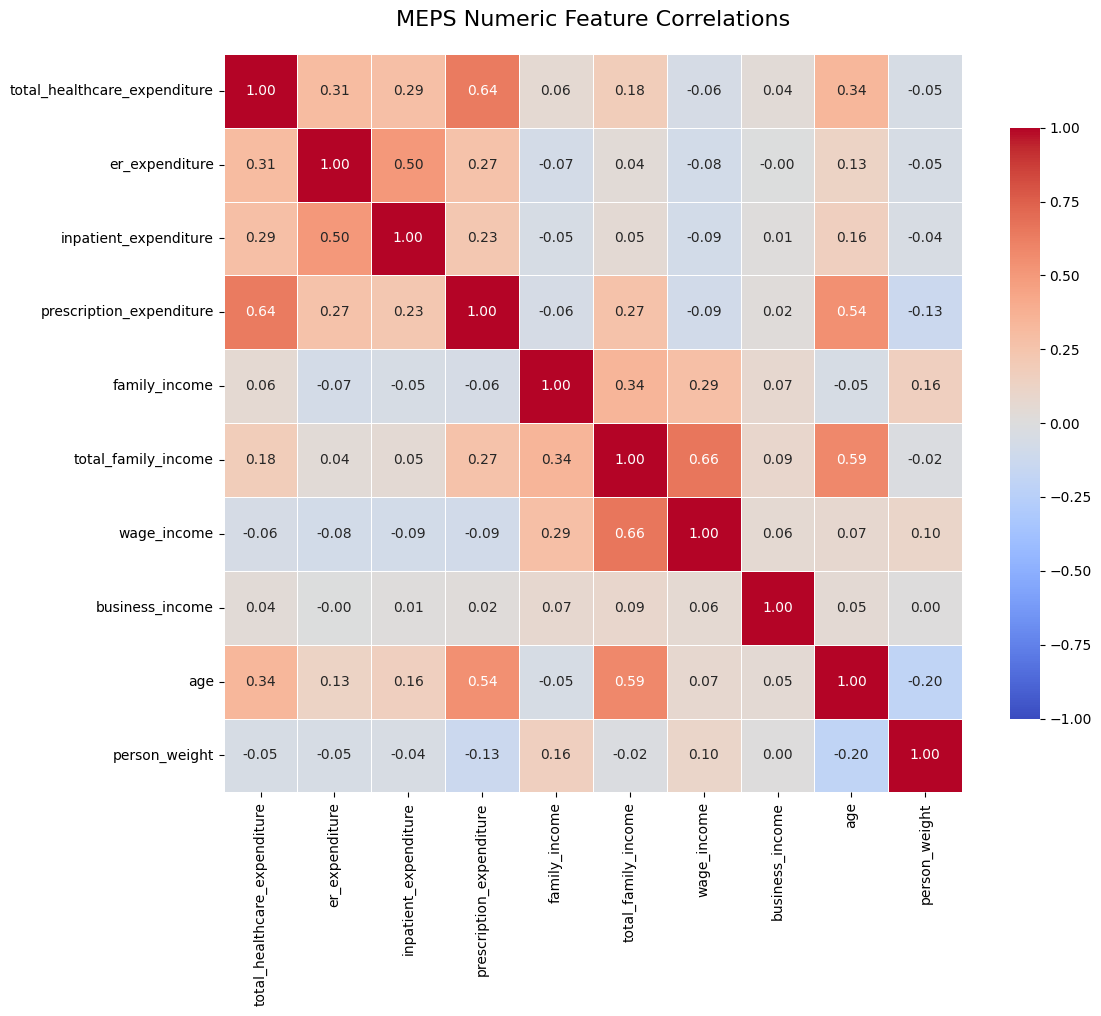

In [44]:
# Hardcoded correlation heatmap for numeric MEPS features

# Clean missing values for all features
total_healthcare_expenditure_clean = clean_meps_missing(meps["total_healthcare_expenditure"])
er_expenditure_clean = clean_meps_missing(meps["er_expenditure"])
inpatient_expenditure_clean = clean_meps_missing(meps["inpatient_expenditure"])
prescription_expenditure_clean = clean_meps_missing(meps["prescription_expenditure"])
family_income_clean = clean_meps_missing(meps["family_income"])
total_family_income_clean = clean_meps_missing(meps["total_family_income"])
wage_income_clean = clean_meps_missing(meps["wage_income"])
business_income_clean = clean_meps_missing(meps["business_income"])
age_clean = clean_meps_missing(meps["age"])
person_weight_clean = clean_meps_missing(meps["person_weight"])

# Apply transformations
total_healthcare_expenditure_log1p = log1p_transform(total_healthcare_expenditure_clean)
er_expenditure_log1p = log1p_transform(er_expenditure_clean)
inpatient_expenditure_log1p = log1p_transform(inpatient_expenditure_clean)
prescription_expenditure_log1p = log1p_transform(prescription_expenditure_clean)
family_income_signed_log1p = signed_log1p_transform(family_income_clean)
total_family_income_signed_log1p = signed_log1p_transform(total_family_income_clean)
wage_income_signed_log1p = signed_log1p_transform(wage_income_clean)
business_income_signed_log1p = signed_log1p_transform(business_income_clean)

# Create correlation dataframe
corr_df = pd.DataFrame({
    "total_healthcare_expenditure": total_healthcare_expenditure_log1p,
    "er_expenditure": er_expenditure_log1p,
    "inpatient_expenditure": inpatient_expenditure_log1p,
    "prescription_expenditure": prescription_expenditure_log1p,
    "family_income": family_income_signed_log1p,
    "total_family_income": total_family_income_signed_log1p,
    "wage_income": wage_income_signed_log1p,
    "business_income": business_income_signed_log1p,
    "age": age_clean,
    "person_weight": person_weight_clean
})

# Compute correlation matrix
correlation_matrix = corr_df.corr()

# Create heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("MEPS Numeric Feature Correlations", fontsize=16, pad=20)
plt.tight_layout()
plt.show()